In [ ]:
## En este modelo aplicamos clasificacion al dataet limpio de German_credit y aplicamos regresion logistica lineas
## que si bien es un modelo lineal predice salidas binarias de {0,1} y positivo y negativo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as nr
import math
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm

%matplotlib inline

In [3]:
data = pd.read_csv('German_credit_preped.csv')
data.head(5)

,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0
3,8740590,< 0 DM,42,current loans paid,furniture/equipment,7882,< 100 DM,4 - 7 years,2,male-single,...,building society savings/life insurance,45,none,for free,1,skilled,2,none,yes,0
4,3924540,< 0 DM,24,past payment delays,car (new),4870,< 100 DM,1 - 4 years,3,male-single,...,unknown-none,53,none,for free,2,skilled,2,none,yes,1


            dummy
bad_credit       
0             700
1             300


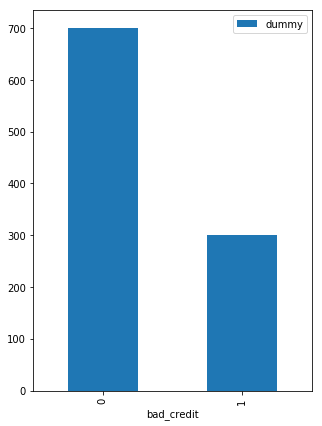

In [19]:
aux = data
aux['dummy'] = 1
total = aux[['dummy','bad_credit']].groupby('bad_credit').count()
print(total)
fig = plt.figure(figsize=(5,7))
ax = fig.gca()
total.plot.bar(ax=ax)

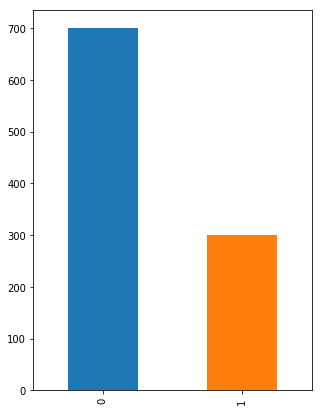

In [23]:
##otra frma de contar estos registros es haciendo un value_count()
total_1 = data['bad_credit'].value_counts()
fig = plt.figure(figsize=(5,7))
ax = fig.gca()
total_1.plot.bar(ax=ax)
plt.show()

In [25]:
## Es importante notar que el data set esta imbalanceado. hay mas del doble de caso que son buenos crditos que malos creditos
## y esto le puede quitar poder de prediccion y clasificacion al modelo.

## preparamos el dataset para scikit learn.

labels = np.array(data['bad_credit'])
labels[:5]

array([0, 1, 0, 0, 1], dtype=int64)

In [49]:
## creamos los enconders para las varibales categoricas.
categorical_columns = ['credit_history', 'purpose', 'gender_status', 
                       'time_in_residence', 'property']
def crea_encoders(datas):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(datas)
    enc_cat_features = enc.transform(datas)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories = 'auto') ##con categories auto evitamos un warning, si lo sacamos no pasa nada.
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

Features = crea_encoders(data['checking_account_status'])
for col in categorical_columns:
    temp = crea_encoders(data[col])
    Features = np.concatenate([Features,temp],axis=1)

print(Features.shape)
print(Features[:2,])   

(1000, 31)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0.]]


In [51]:
### Agregamos las columnas numericas.

Features = np.concatenate([Features,data[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']]],axis=1)

In [52]:
print(Features.shape)
print(Features[:2,])

(1000, 35)
[[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 6.000e+00 1.169e+03 4.000e+00 6.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 4.800e+01 5.951e+03 2.000e+00 2.200e+01]]


In [71]:
## ahora hacemos un split en el dataset, de entrenamiento y test.
nr.seed(9988)
indx = range(Features.shape[0]) ## creams un indice con valores de 1 a la cantidad de registros .
indx = ms.train_test_split(indx, test_size = 300) ## esta funcion toma 300 casos aleatorios sobre el indice creado
x_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
x_test = Features[indx[1],:] ## en indx[2] estan los valores que quedaron afuera de test_size = 300
y_test = np.ravel(labels[indx[1]])

In [74]:
## escalamos los valores numericos.

scaler = preprocessing.StandardScaler().fit(x_train[:,34:])
x_train[:,34:] = scaler.transform(x_train[:,34:])
x_test[:,34:] = scaler.transform(x_test[:,34:])
print(x_train.shape)
print(x_train[:1,:])

(700, 35)
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e+00  0.00000000e+00  3.90000000e+01
   4.93300000e+03  2.00000000e+00 -9.33823618e-01]]


In [77]:
## con os datos segmentados y transformados aplicamos el modelo de Clasificacion usando regresion lineal logistica.

logistic_mod = linear_model.LogisticRegression()
logistic_mod.fit(x_train, y_train)

print(logistic_mod.coef_)
print(logistic_mod.intercept_)

[[-1.59189053e-02  7.39179063e-01 -2.94121425e-01 -1.19641550e+00
   3.97865320e-01 -1.12457443e+00 -4.21853375e-01  7.52608190e-01
  -3.71322469e-01 -6.79112015e-02  4.94537270e-01 -6.47565419e-01
   1.06950076e-01  1.34970973e-01  1.96821115e-02 -2.45734335e-01
  -4.09744722e-01  6.00656875e-02 -2.12527206e-01 -1.09411630e-01
   5.01120577e-02 -8.89328227e-02 -6.19044371e-01 -5.57304806e-01
   2.16408591e-01 -3.80663214e-01 -4.57173378e-02 -2.70136101e-01
  -1.02901959e-01 -5.25308845e-01  1.31070139e-01  2.28993005e-02
   5.97242265e-05  2.04552548e-01 -1.83632694e-01]]
[-0.76727677]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [79]:
## como es una modelo decalsificacion trabajamo con probabilidades, calculamos la probabilidad sobre x_test
proba = logistic_mod.predict_proba(x_test)
print(proba[:15,:])

[[0.84578137 0.15421863]
 [0.40077484 0.59922516]
 [0.94197945 0.05802055]
 [0.31665674 0.68334326]
 [0.54805099 0.45194901]
 [0.97412262 0.02587738]
 [0.94821737 0.05178263]
 [0.62816941 0.37183059]
 [0.874236   0.125764  ]
 [0.92512235 0.07487765]
 [0.55958235 0.44041765]
 [0.40214094 0.59785906]
 [0.5047957  0.4952043 ]
 [0.67346761 0.32653239]
 [0.34062066 0.65937934]]


In [86]:
proba[:,0].reshape(-1,1) ## la columna 0 corresponde a bar_credit = 0 (buen credito)

array([[0.84578137],
       [0.40077484],
       [0.94197945],
       [0.31665674],
       [0.54805099],
       [0.97412262],
       [0.94821737],
       [0.62816941],
       [0.874236  ],
       [0.92512235],
       [0.55958235],
       [0.40214094],
       [0.5047957 ],
       [0.67346761],
       [0.34062066],
       [0.31672689],
       [0.40738805],
       [0.91569461],
       [0.74599908],
       [0.90135975],
       [0.80278706],
       [0.62459776],
       [0.56048954],
       [0.23655407],
       [0.72964193],
       [0.88734509],
       [0.17211445],
       [0.52440195],
       [0.81766964],
       [0.91811346],
       [0.83448067],
       [0.60832351],
       [0.47648994],
       [0.88633453],
       [0.91518075],
       [0.87993112],
       [0.60506743],
       [0.87364272],
       [0.64049144],
       [0.86041006],
       [0.88201824],
       [0.49623868],
       [0.71877691],
       [0.48537006],
       [0.34674135],
       [0.77334071],
       [0.6993619 ],
       [0.861

In [96]:
def crea_modelo_score(probas, trash):
    return np.array([1 if x > trash else 0 for x in probas[:,1]])

scores = crea_modelo_score(proba,0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


In [138]:
## creamos una funcion para visualizar los principales indicadores. y usamos dos funciones una áta metricas
## y otra para matrix de confusion

def crea_indicadores(y_test, scores):
    metricas = sklm.precision_recall_fscore_support(y_test,scores)
    conf = sklm.confusion_matrix(y_test, scores)
    print('Matris de confucion:')
    print('                     Positivos     Negativos')
    print('True positive        ' + str(conf[0,0]) + '           ' + str(conf[1,0]))
    print('True negative        ' + str(conf[1,0]) + '            ' + str(conf[1,1]))
    print('\n')
    print('Accurancy             %6.2f' %sklm.accuracy_score(y_test,scores))
    print('Metricas importantes')
    print('                     Positivos     Negativos')
    print('Numero de casos      ' + str(metricas[3][0]) + '           ' + str(metricas[3][1]))
    print('Precision          %6.2f' % metricas[0][0] + '        %6.2f'  % metricas[0][1])
    print('Recall             %6.2f' % metricas[1][0] + '        %6.2f' % metricas[1][1])
    print('F1                 %6.2f' %metricas[2][0]+ '        %6.2f' %metricas[2][1])

crea_indicadores(y_test, scores)

Matris de confucion:
                     Positivos     Negativos
True positive        182           39
True negative        39            49


Accurancy               0.77
Metricas importantes
                     Positivos     Negativos
Numero de casos      212           88
Precision            0.82          0.62
Recall               0.86          0.56
F1                   0.84          0.59


In [ ]:
##observacion: se ve que clasifica bien los posticos 182 contra 39 mal clasificados pero como desbalanceo de clases falla en los
## negativos.

## Tenemos 212 positovs contra apenas 88 negativos y F1 nos deci que 84 % de aciertos para positivos verdaderos pero 
## clasifica 59% como negativos. Y estos casos negativos son los que mas le importan al banco.

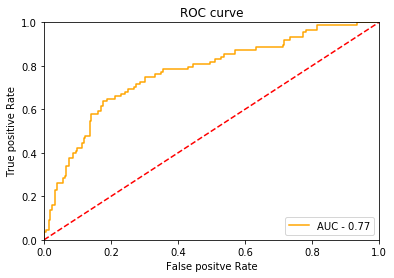

In [144]:
def dibuja_roc_curve(y_test,probabilidades):
    fps, trs, trash = sklm.roc_curve(y_test, probabilidades[:,1])
    auc = sklm.auc(fps,trs)
    
    plt.title('ROC curve')
    plt.plot(fps,trs, color = 'orange', label = 'AUC - %0.2f' %auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylim([0,1])
    plt.xlim([0,1])
    plt.xlabel('False positve Rate')
    plt.ylabel('True positive Rate')
    plt.show()
    
dibuja_roc_curve(y_test,proba)    

Matris de confucion:
                     Positivos     Negativos
True positive        212           88
True negative        88            0


Accurancy               0.71
Metricas importantes
                     Positivos     Negativos
Numero de casos      212           88
Precision            0.71          0.00
Recall               1.00          0.00
F1                   0.83          0.00


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


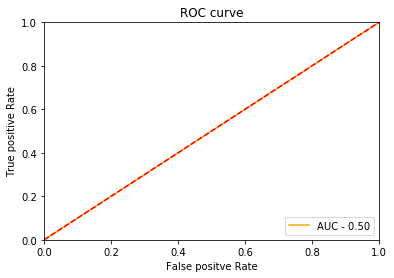

In [151]:
## Vemos que el modelo tiene un AUC de 0.77 pero como podemos saber que tan bueno es. 
## Un metodo es hacer que todos los casos en el set de probs sea postivos y medirlo contra esto (Crear un modelo naive)

proba_positive = np.concatenate((np.ones((proba.shape[0],1)), np.zeros((proba.shape[0],1))), axis = 1)
score_positives = crea_modelo_score(proba_positive,0.5)
crea_indicadores(y_test, score_positives)
dibuja_roc_curve(y_test, proba_positive)

In [153]:
### El AUC esta directamente sobre la linea de 0.5 y  el accuracy es de 0.71 lo que demuestra que es una clase imbalanceada.
## el modelo de regresion logistica es mucho mejor que este.

##Intentamos mejorar el modelo modificando los pesos del algoritmo.

logistic_mod = linear_model.LogisticRegression(class_weight={0:45,1:55})
logistic_mod.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight={0: 45, 1: 55}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [155]:
proba =  logistic_mod.predict_proba(x_test)
print(proba[:15])

[[0.82221925 0.17778075]
 [0.33655263 0.66344737]
 [0.93720028 0.06279972]
 [0.28444805 0.71555195]
 [0.49546234 0.50453766]
 [0.97493554 0.02506446]
 [0.95047332 0.04952668]
 [0.58765302 0.41234698]
 [0.8631795  0.1368205 ]
 [0.92473006 0.07526994]
 [0.51264415 0.48735585]
 [0.35224675 0.64775325]
 [0.45548381 0.54451619]
 [0.60767704 0.39232296]
 [0.29695009 0.70304991]]


Matris de confucion:
                     Positivos     Negativos
True positive        175           34
True negative        34            54


Accurancy               0.76
Metricas importantes
                     Positivos     Negativos
Numero de casos      212           88
Precision            0.84          0.59
Recall               0.83          0.61
F1                   0.83          0.60


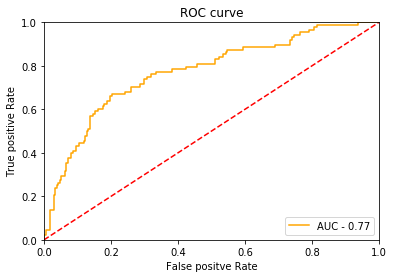

In [157]:
score_positives = crea_modelo_score(proba,0.5)
crea_indicadores(y_test, score_positives)
dibuja_roc_curve(y_test, proba)

In [158]:
### tratamos de mejorar el modelo cambiando los trasholdt

def improve_model(prob, y_test, trash):
    scores = crea_modelo_score(prob, trash)
    print('Para el trash : ' + str(trash))
    crea_indicadores(y_test,scores)
    
trash = [0.1,0.2,0.3,0.35,0.45,0.65,0.7,0.8,0.85,0.90,0.95,0.99]
for t in trash:
    improve_model(proba,y_test,t)

Para el trash : 0.1
Matris de confucion:
                     Positivos     Negativos
True positive        41           2
True negative        2            86


Accurancy               0.42
Metricas importantes
                     Positivos     Negativos
Numero de casos      212           88
Precision            0.95          0.33
Recall               0.19          0.98
F1                   0.32          0.50
Para el trash : 0.2
Matris de confucion:
                     Positivos     Negativos
True positive        101           15
True negative        15            73


Accurancy               0.58
Metricas importantes
                     Positivos     Negativos
Numero de casos      212           88
Precision            0.87          0.40
Recall               0.48          0.83
F1                   0.62          0.54
Para el trash : 0.3
Matris de confucion:
                     Positivos     Negativos
True positive        127           19
True negative        19            69


Accur

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
